In [2]:
import pipic
from pipic import consts, types
import matplotlib.pyplot as plt
import numpy as np
from numba import cfunc, carray
import os, time


# ===========================SIMULATION INITIALIZATION===========================
temperature = 1e-6 * consts.electron_mass * consts.light_velocity**2
density = 1e+18
debye_length = np.sqrt(temperature / (4*np.pi * density * consts.electron_charge**2))
plasma_period = np.sqrt(np.pi * consts.electron_mass / (density * consts.electron_charge**2))
l = 128*debye_length
xmin, xmax = -l/2, l/2
field_amplitude = 0.01*4*np.pi * (xmax-xmin) * consts.electron_charge * density
nx = 128
time_step = plasma_period/64

# ---------------------setting solver and simulation region----------------------
sim = pipic.init(solver='ec', nx=nx, xmin=xmin, xmax=xmax)

# ------------------------------adding electrons---------------------------------
@cfunc(types.add_particles_callback)
def density_callback(r, data_double, data_int):
    return density * (abs(r[0]) < l/4)

sim.add_particles(name='electron', number=500*nx,
                  charge=-consts.electron_charge, mass=consts.electron_mass,
                  temperature=temperature, density=density_callback.address)

# ---------------------------setting initial field-------------------------------
@cfunc(types.field_loop_callback)
def setField_callback(ind, r, E, B, data_double, data_int):
    E[0] = field_amplitude * np.sin(4*np.pi * r[0] / (xmax-xmin)) * (abs(r[0]) < l/4)

sim.field_loop(handler=setField_callback.address)


# =================================OUTPUT========================================
fig, axs = plt.subplots(2, constrained_layout=True)

# -------------preparing output for electron distribution f(x, px)--------------
xpx_dist = np.zeros((64, 128), dtype=np.double)
pxLim = 5 * np.sqrt(temperature * consts.electron_mass)
inv_dx_dpx = (xpx_dist.shape[1] / (xmax-xmin)) * (xpx_dist.shape[0] / (2 * pxLim))

@cfunc(types.particle_loop_callback)
def xpx_callback(r, p, w, id, data_double, data_int):
    ix = int(xpx_dist.shape[1] * (r[0] - xmin) / (xmax-xmin))
    iy = int(xpx_dist.shape[0] * 0.5 * (1 + p[0] / pxLim))
    data = carray(data_double, xpx_dist.shape, dtype=np.double)
    if iy >= 0 and iy < xpx_dist.shape[0]:
        data[iy, ix] += w[0] * inv_dx_dpx / (3*density/pxLim)

axs[0].set_title('$\partial N / \partial x \partial p_x$ (s g$^{-1}$cm$^{-2}$)')
axs[0].set(ylabel='$p_x$ (cm g/s)')
axs[0].xaxis.set_ticklabels([])
plot0 = axs[0].imshow(xpx_dist, vmin=0, vmax=1,
                      extent=[xmin, xmax, -pxLim, pxLim], interpolation='none',
                      aspect='auto', cmap='YlOrBr')
fig.colorbar(plot0, ax=axs[0], location='right')

def plot_xpx():
    xpx_dist.fill(0)
    sim.particle_loop(name='electron', handler=xpx_callback.address,
                      data_double=pipic.addressof(xpx_dist))
    plot0.set_data(xpx_dist)

# -------------------------preparing output of Ex(x)-----------------------------
Ex = np.zeros((32,), dtype=np.double)

@cfunc(types.it2r_callback)
def Ex_it2r(it, r, data_double, data_int):
    r[0] = xmin + (it[0] + 0.5) * (xmax-xmin) / Ex.shape[0]

@cfunc(types.field2data_callback)
def get_Ex(it, r, E, B, data_double, data_int):
    data_double[it[0]] = E[0]

axs[1].set_xlim([xmin, xmax])
axs[1].set_ylim([-field_amplitude, field_amplitude])
axs[1].set(xlabel='$x$ (cm)', ylabel='$E_x$ (cgs units)')
x_axis = np.linspace(xmin, xmax, Ex.shape[0])
plot_Ex_, = axs[1].plot(x_axis, Ex)

def plot_Ex():
    sim.custom_field_loop(number_of_iterations=Ex.shape[0], it2r=Ex_it2r.address,
                          field2data=get_Ex.address, data_double=pipic.addressof(Ex))
    plot_Ex_.set_ydata(Ex)

# ===============================SIMULATION======================================
save_gif = False # set to False to show with scrollbar

import numpy as np
from matplotlib import animation
from IPython.display import HTML, display, clear_output, Image


frames = 64
counter = 0
def animate(i):
    sim.advance(time_step=time_step, number_of_iterations=4)
    plot_xpx()
    plot_Ex()
    global counter
    clear_output()
    if counter <= frames:
        display(HTML('<pre> Progress: ' + "{:.2f}".format(100*counter/frames) + '%</pre>'), display_id = True)
    counter += 1
    return 

ani = animation.FuncAnimation(fig, animate,frames=frames, interval = 40);
with open('pipic_performance.txt', 'r') as f:
    print(f.read())

if save_gif == False:
    html = HTML(ani.to_jshtml())
    display(html)
    plt.close()
else:
    writer = animation.PillowWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('output_basci_example.gif', writer=writer)

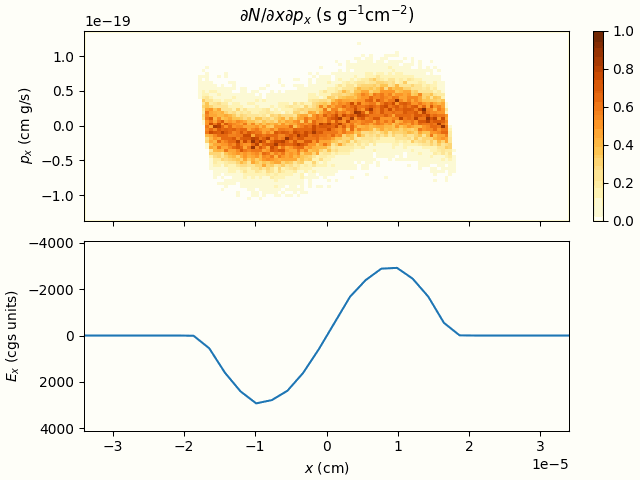

In [27]:
Image('output_basci_example.gif')